## Imports

In [1]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
import cv2
from tensorflow.keras import layers, initializers, applications
from tensorflow.keras.layers import Conv2D, Dropout, MaxPooling2D, Conv2DTranspose, concatenate, Input
from tensorflow.keras.initializers import random_uniform, glorot_uniform
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical


## Turn on GPU

In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
  try:
    tf.config.set_logical_device_configuration(
        gpus[0],
        [tf.config.LogicalDeviceConfiguration(memory_limit=1024*10)])
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

2022-07-10 19:23:03.365097: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-10 19:23:03.447710: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-10 19:23:03.448514: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


1 Physical GPUs, 1 Logical GPUs


2022-07-10 19:23:03.457162: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-10 19:23:03.457466: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-10 19:23:03.458191: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-10 19:23:03.458974: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

## Preprocessing

### Define functions

In [3]:
def label_encoder(mask_dataset):
    labelencoder = LabelEncoder()
    n, h, w = mask_dataset.shape  
    mask_dataset_reshaped = mask_dataset.reshape(-1,1)
    mask_dataset_reshaped_encoded = labelencoder.fit_transform(mask_dataset_reshaped)
    mask_dataset_encoded = mask_dataset_reshaped_encoded.reshape(n, h, w)
    
    return mask_dataset_encoded

def categorical(y_train, n_classes):
    train_masks_cat = to_categorical(y_train, num_classes=n_classes)
    y_train_cat = train_masks_cat.reshape((y_train.shape[0], y_train.shape[1], y_train.shape[2], n_classes))
    
    return y_train_cat


def read_tile(path_X, path_y, size=(544, 480)):
    sorted_X = sorted(os.listdir(path_X), key = str)
    sorted_y = sorted(os.listdir(path_y), key = str)
    length = len(sorted_X)
    
    items_X = [os.path.join(path_X, sorted_X[i]) for i in range(length)]
    items_y = [os.path.join(path_y, sorted_y[i]) for i in range(length)]

    X = np.array([cv2.imread(items_X[i], 1)[:size[0], :size[1]] for i in range(length)])
    y = np.array([cv2.imread(items_y[i], 0)[:size[0], :size[1]] for i in range(length)])

    y = label_encoder(y)
    
    return X, y
    
    
def read_data(main_path, image_path, mask_path, n_tails=8, size=(544, 480)):
    
    features = []
    target = []
    for i in range(1, n_tails+1):
        main_image_path = os.path.join(main_path, 'Tile '+str(i), image_path)
        main_mask_path = os.path.join(main_path, 'Tile '+str(i), mask_path)

        X, y = read_tile(main_image_path, main_mask_path)
        features.append(X)
        target.append(y)
        
    features = np.array(features)
    features = features.reshape((features.shape[0]*features.shape[1], features.shape[2], features.shape[3], features.shape[4]))
    target = np.array(target)
    target = target.reshape((target.shape[0]*target.shape[1], target.shape[2], target.shape[3]))
    
    return features, target

def show_images(images, masks, nx=2, ny=4, figsize=(10, 10)):
    plt.figure(figsize=figsize)
    plt.axis("off")

    for i in range(0, nx*ny):
        if i < nx*ny // 2:
            ax = plt.subplot(nx, ny, i+1)
            plt.imshow(images[i])
        else:
            ax = plt.subplot(nx, ny, i+1)
            plt.imshow(masks[i-nx*ny//2])

        
def data_split(X, y, train_rate=0.6, test=True):
    if not test :
        val_rate = 1-train_rate
    else :
        val_rate = (1-train_rate)/2
    
    length = X.shape[0]
    n_train = int(train_rate*length)
    n_val = int(val_rate*length)

    
    X_train, y_train = X[:n_train], y[:n_train]
    X_val, y_val = X[n_train:n_train+n_val], y[n_train:n_train+n_val]
    
    if test:
        X_test, y_test = X[n_train+n_val:], y[n_train+n_val:]
        return (X_train, y_train), (X_val, y_val), (X_test, y_test)
    else:
        return (X_train, y_train), (X_val, y_val) 
    
    

### Load data

In [4]:
main_path = '../input/semantic-segmentation-of-aerial-imagery/Semantic segmentation dataset'
image_path = 'images'
mask_path = 'masks'

In [5]:
X, y = read_data(main_path, image_path, mask_path)

/opt/conda/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [6]:
X = X/255.

In [7]:
print("Shape(X) = {}".format(X.shape))
print("Shape(y) = {}".format(y.shape))

Shape(X) = (72, 544, 480, 3)
Shape(y) = (72, 544, 480)


Here we show some images with the assocoated masks

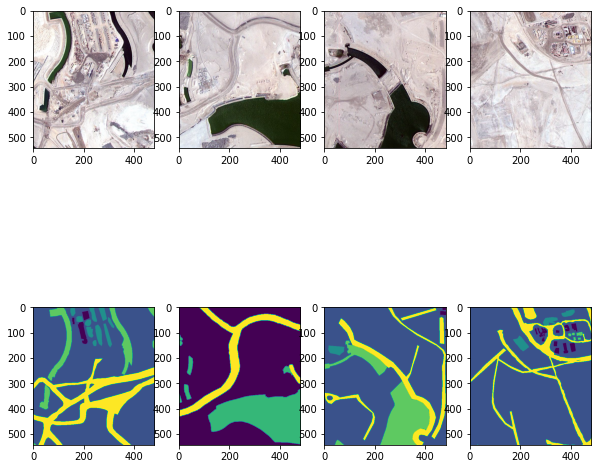

In [8]:
show_images(X, y)

### Splitting data

We can split data into training set and validation set only as we can ad test set

In [9]:
(X_train, y_train), (X_val, y_val), (X_test, y_test) = data_split(X, y, train_rate=0.7)

print("Number of training examples  : {}".format(X_train.shape[0]))
print("Numer of validation examples : {}".format(X_val.shape[0]))
print("Number of test examples      : {}".format(X_test.shape[0]))

Number of training examples  : 50
Numer of validation examples : 10
Number of test examples      : 12


## Model

### Variables

In [10]:
IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]
input_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

n_classes = len(np.unique(y))

### U-NET

In [11]:
import tensorflow as tf
from tensorflow import keras
from keras import layers, initializers, applications
from keras.layers import Conv2D, Dropout, MaxPooling2D, Conv2DTranspose, concatenate, Input
from keras.initializers import random_uniform, glorot_uniform

### Semantic segmentation with U-Net
## Conv Block : downsampling block (encoder)
def conv_block(inputs=None, n_filters=32, dropout_prob=0, max_pooling=True):
    conv = Conv2D(n_filters, kernel_size=3, activation='relu', padding='same', kernel_initializer= 'he_normal')(inputs)
    conv = Conv2D(n_filters, 3, activation='relu', padding='same', kernel_initializer= 'he_normal')(conv)
    
    # if dropout_prob > 0 add a dropout layer, with the variable dropout_prob as parameter
    if dropout_prob > 0:
        conv = Dropout(dropout_prob)(conv)
        
    # if max_pooling is True add a MaxPooling2D with 2x2 pool_size
    if max_pooling:
        # We devide the height and the width by 2
        next_layer = MaxPooling2D(2,strides=2)(conv)
        
    else:
        next_layer = conv
        
    skip_connection = conv
    
    return next_layer, skip_connection

## Upsampling block (decoder)

def upsampling_block(expansive_input, contractive_input, n_filters=32):
    
    # Multiply the height and the width of the tensor by 2
    up = Conv2DTranspose(n_filters, kernel_size=3, strides=2, padding='same')(expansive_input)

    # Merge the previous output and the contractive_input
    merge = concatenate([up, contractive_input], axis=3)

    conv = Conv2D(n_filters, kernel_size=3, activation='relu', padding='same', kernel_initializer= 'he_normal')(merge)
    conv = Conv2D(n_filters, 3, activation='relu', padding='same', kernel_initializer= 'he_normal')(conv)
    
    return conv

### The model
## n_classes : number of output channels

def unet_model(input_size=(96, 128, 3), n_filters=32, n_classes=23):

    inputs = Input(input_size)
    # Contracting Path (encoding)
    # Add a conv_block with the inputs of the unet_ model and n_filters
    cblock1 = conv_block(inputs=inputs, n_filters=n_filters*1)
    # Chain the first element of the output of each block to be the input of the next conv_block. 
    # Double the number of filters at each new step
    cblock2 = conv_block(inputs=cblock1[0], n_filters=n_filters*2)
    cblock3 = conv_block(inputs=cblock2[0], n_filters=n_filters*4)
    # Include a dropout of 0.3 for this layer
    cblock4 = conv_block(inputs=cblock3[0], n_filters=n_filters*8,dropout_prob=0.3)
    # Include a dropout of 0.3 for this layer, and avoid the max_pooling layer
    cblock5 = conv_block(inputs=cblock4[0], n_filters=n_filters*16,dropout_prob=0.3, max_pooling=False) 


    # Expanding Path (decoding)
    # Add the first upsampling_block.
    # From here,at each step, use half the number of filters of the previous block 
    # Use the cblock5[0] as expansive_input and cblock4[1] as contractive_input and n_filters * 8
    ublock6 = upsampling_block(cblock5[0], cblock4[1], n_filters*8)
    # Chain the output of the previous block as expansive_input and the corresponding contractive block output.
    # Note that you must use the second element of the contractive block i.e before the maxpooling layer. 
    
    ublock7 = upsampling_block(ublock6, cblock3[1], n_filters*4)
    ublock8 = upsampling_block(ublock7, cblock2[1], n_filters*2)
    ublock9 = upsampling_block(ublock8, cblock1[1], n_filters*1)

    conv9 = Conv2D(n_filters,
                 3,
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(ublock9)

    # Add a Conv2D layer with n_classes filter, kernel size of 1 and a 'same' padding
    conv10 = Conv2D(n_classes, 1, padding='same')(conv9)
    
    model = tf.keras.Model(inputs=inputs, outputs=conv10)

    return model

### Create, compile and fit the model

In [12]:
model = unet_model(input_size=input_shape, n_classes=n_classes)

model.compile(
    optimizer = keras.optimizers.Adam(),
    loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics = ['accuracy']
)

In [13]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(
    min_delta=0.001,
    patience=8,
    restore_best_weights=True,
)

In [14]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), verbose=1, epochs=10, batch_size=4, callbacks=[early_stopping])

2022-07-10 19:23:12.438812: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10


2022-07-10 19:23:14.494033: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


13/13 [==============================] - 15s 356ms/step - loss: 1.8208 - accuracy: 0.2210 - val_loss: 1.6752 - val_accuracy: 0.1069
Epoch 2/10
13/13 [==============================] - 2s 186ms/step - loss: 1.6005 - accuracy: 0.3903 - val_loss: 1.9401 - val_accuracy: 0.3386
Epoch 3/10
13/13 [==============================] - 2s 186ms/step - loss: 1.4910 - accuracy: 0.4210 - val_loss: 1.5257 - val_accuracy: 0.2370
Epoch 4/10
13/13 [==============================] - 2s 186ms/step - loss: 1.4896 - accuracy: 0.3746 - val_loss: 1.3549 - val_accuracy: 0.2680
Epoch 5/10
13/13 [==============================] - 2s 185ms/step - loss: 1.4183 - accuracy: 0.4691 - val_loss: 1.2382 - val_accuracy: 0.2748
Epoch 6/10
13/13 [==============================] - 2s 184ms/step - loss: 1.3494 - accuracy: 0.4073 - val_loss: 1.1771 - val_accuracy: 0.6686
Epoch 7/10
13/13 [==============================] - 2s 184ms/step - loss: 1.3260 - accuracy: 0.4578 - val_loss: 1.2830 - val_accuracy: 0.2813
Epoch 8/10
13/13

## Debugging

In [15]:
def learning_curve(history, figsize=(8, 8), debug_type = 'both'):
    hist = history

    if debug_type == 'loss' or debug_type == 'both':
        plt.figure(figsize=figsize)
        plt.plot(hist['loss'])
        plt.plot(hist['val_loss'])
        plt.xlabel('epochs')
        plt.ylabel('loss')
        plt.legend(['Training cost', 'Validation cost'])

    if debug_type == 'accuracy' or debug_type == 'both':
        plt.figure(figsize=figsize)
        plt.plot(hist['accuracy'])
        plt.plot(hist['val_accuracy'])
        plt.xlabel('epochs')
        plt.ylabel('loss')
        plt.legend(['Training accuracy', 'Validation accuracy'])

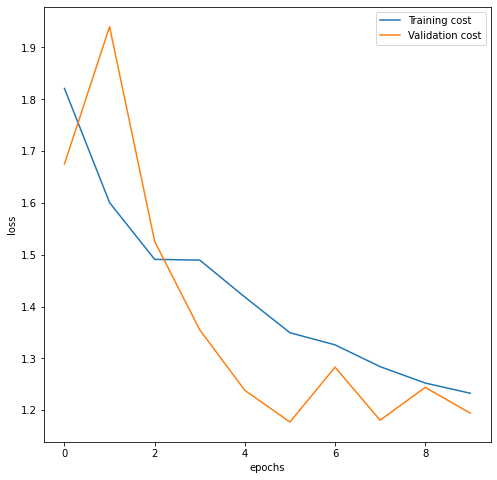

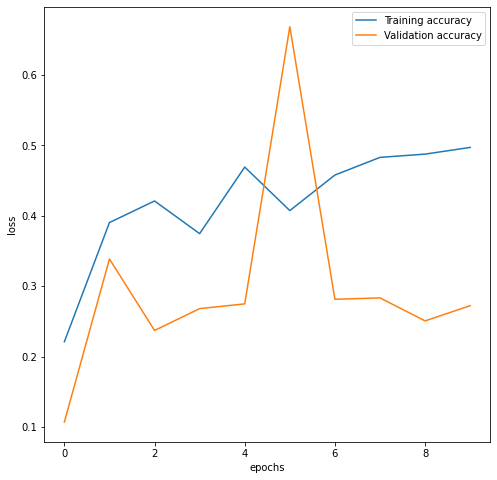

In [16]:
learning_curve(history.history)

The model is less performant because of lack of data.

## Making predictions

In [17]:
y_pred = model.predict(X_test)
y_pred.shape

(12, 544, 480, 7)

In [18]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    return pred_mask

In [19]:
y_mask = create_mask(y_pred)

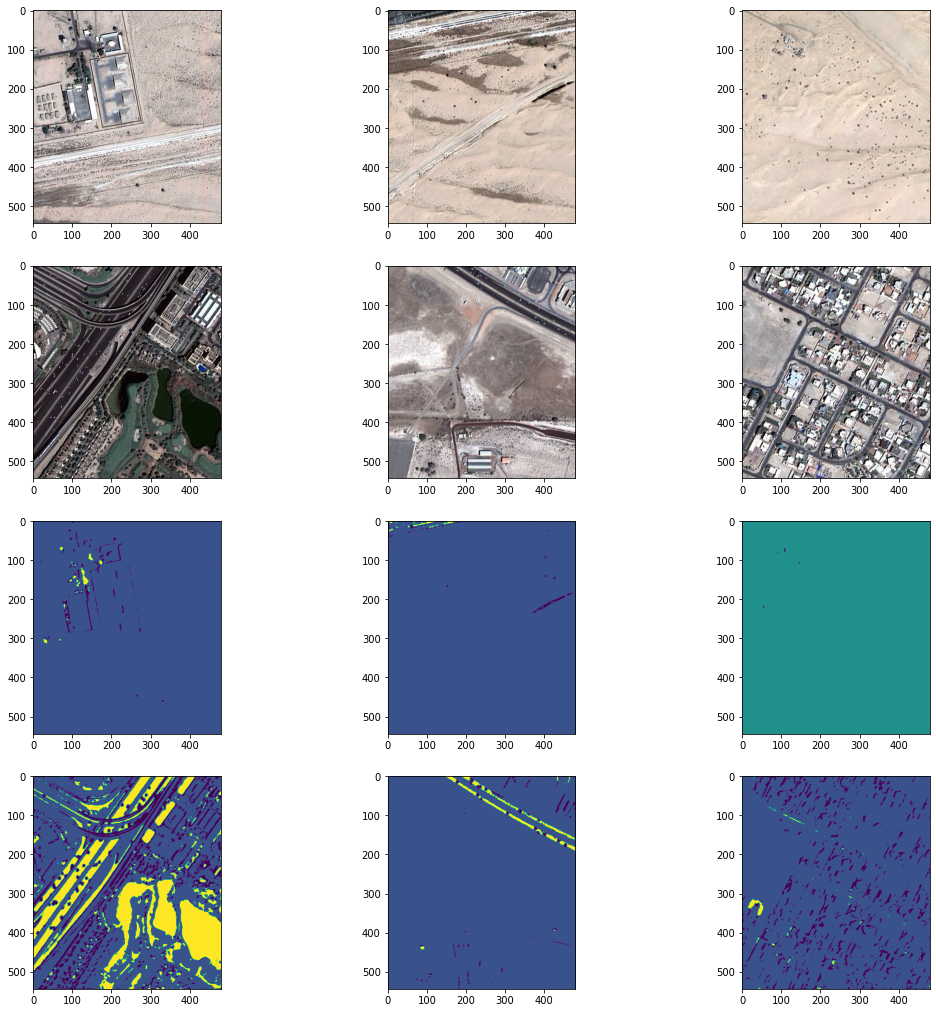

In [20]:
show_images(X_test, y_mask, nx=4, ny=3, figsize=(18, 18))

## Save model

In [21]:
model.save('../sgAerialImagery.h5')